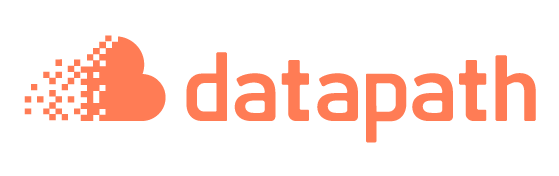

# **Análisis de datos con Python: Taller**


## **Consigna**

Aplicar un modelo de predicción sobre el desafío de Kaggle "Pulsar Classification For Class Prediction":

https://www.kaggle.com/datasets/brsdincer/pulsar-classification-for-class-prediction

Resumen de los requisitos para el taller:

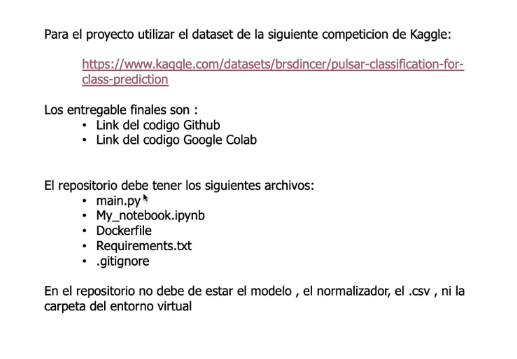

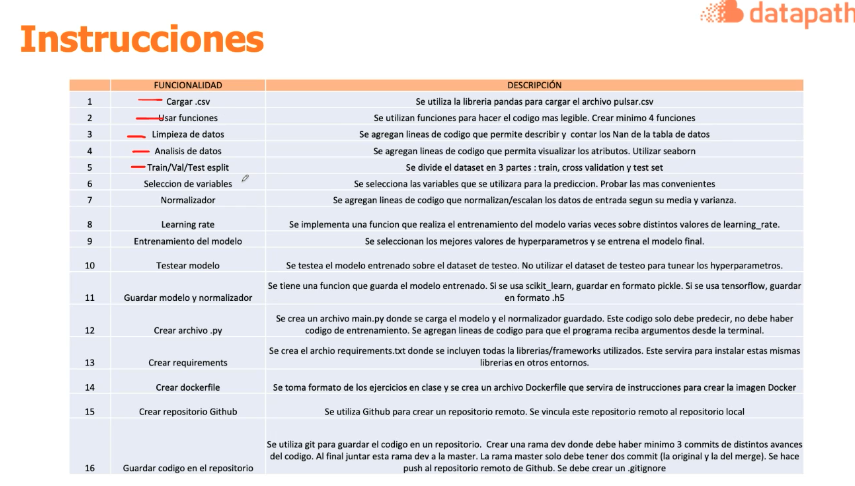

**Descripción de las variables:**

Pulsar Classification For Class Prediction: 17898 entries


Data can be useful for prediction models of classification.


COLUMNS:
Based on Integrated Profile of Observation

Mean_Integrated: Mean of Observations

SD: Standard deviation of Observations

EK: Excess kurtosis of Observations

Skewness: In probability theory and statistics, skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. Skewness of Observations.


Mean _ DMSNR _ Curve: Mean of DM SNR CURVE of Observations

SD _ DMSNR _ Curve: Standard deviation of DM SNR CURVE of Observations

EK _ DMSNR _ Curve: Excess kurtosis of DM SNR CURVE of Observations

Skewness _ DMSNR _ Curve: Skewness of DM SNR CURVE of Observations

Class: Class 0 - 1


WHAT IS DM SNR CURVE:


Radio waves emitted from pulsars reach earth after traveling long distances in space which is filled with free electrons. The important point is that pulsars emit a wide range of frequencies, and the amount by which the electrons slow down the wave depends on the frequency. Waves with higher frequency are sowed down less as compared to waves with higher frequency. It means dispersion.


TARGET:


Class
0 -- It is not
1 -- It is



##**Taller: se ejecutan los pasos**

### **1) Carga de librerías e importación del dataset en CSV**

In [93]:
#Importo las librerías que voy a usar
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier # modelo con árboles de decisión similar a XGBoost
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA

import time

In [3]:
# Importo el dataset
Pulsar = pd.read_csv("/content/Pulsar.csv")

### **2) Se predefine el modelo de predicción: "Hist Gradient Boosting Classifier" de scikit-learn**

Basado en árboles de decisión, el "Hist Gradient Boosting Classifier" (similar a XGBoost, aunque algo menos eficiente para grandes volúmenes de datos), es uno de los modelos más utilizados y efectivos para el desarrollo de soluciones para problemas de clasificación. Es por tal motivo, que se selecciona este modelo por sobre otros para el problema a resolver. Se adjunta link de Scikit-learn con todos los parámetros y atributos disponibles:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier

### **3) Se crean funciones de para facilitar el análisis y desarrollo del modelo**

In [4]:
#Función 1: Análisis de datasets
def analisis (base):
    print(base.shape)
    print('-------------------------------------------')
    print(type(base))
    print('-------------------------------------------')
    print(base.describe())
    return

In [5]:
#Función 2: Gráfico Curva ROC y AUC (área bajo la curva)
def grafico (modelo,x,y):
    fpr, tpr, threshold = roc_curve(x, y)
    roc_auc = auc(fpr, tpr)

    plt.title(f'ROC Curve - {modelo}')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.show()
    return

In [6]:
#Función 3: Entrenamiento del dataset
def training_ds (model,x,y,lr,md,mi):
    start_time = time.time()

    model = HistGradientBoostingClassifier(learning_rate= lr,max_depth = md,max_iter = mi)
    model = model.fit(x, y)

    end_time = time.time()
    return print('\nElapsed training time: {:.5f} seconds'.format(end_time-start_time))

In [7]:
#Función 4: Testeo del entrenamiento (matriz de confusión, accuracy, recall, precision)
def training_res (x,y):
      print("Se visualiza la matriz de confusión de los valores reales y su predicción:")
      matriz = confusion_matrix(x, y)
      print(matriz)
      print('-------------------------------------------')
      print("Acurracy / Exactitud del modelo:")
      exactitud = accuracy_score(x, y)
      print(round(exactitud,4))
      print('-------------------------------------------')
      print("Precisión del modelo:")
      precision = precision_score(x, y)
      print(round(precision,4))
      print('-------------------------------------------')
      print("Recall del modelo:")
      recall = recall_score(x, y)
      print(round(recall,4))
      return

### **4) Análisis del dataset y conclusiones preliminares previo al desarrollo del modelo**

In [15]:
print(Pulsar.head(6))

   Mean_Integrated         SD        EK  Skewness  Mean_DMSNR_Curve  \
0       140.562500  55.683782 -0.234571 -0.699648          3.199833   
1       102.507812  58.882430  0.465318 -0.515088          1.677258   
2       103.015625  39.341649  0.323328  1.051164          3.121237   
3       136.750000  57.178449 -0.068415 -0.636238          3.642977   
4        88.726562  40.672225  0.600866  1.123492          1.178930   
5        93.570312  46.698114  0.531905  0.416721          1.636288   

   SD_DMSNR_Curve  EK_DMSNR_Curve  Skewness_DMSNR_Curve  Class  
0       19.110426        7.975532             74.242225      0  
1       14.860146       10.576487            127.393580      0  
2       21.744669        7.735822             63.171909      0  
3       20.959280        6.896499             53.593661      0  
4       11.468720       14.269573            252.567306      0  
5       14.545074       10.621748            131.394004      0  


In [16]:
#Corroboro que esta sea la variable a predecir, sabiendo en la página de la competencia que es
# un desafío de clasificación binaria
print(Pulsar.Class.unique())

[0 1]


In [17]:
#Corroboro si el dataset Pulsar tiene variables Nan
Pulsar.isna().sum()

Mean_Integrated         0
SD                      0
EK                      0
Skewness                0
Mean_DMSNR_Curve        0
SD_DMSNR_Curve          0
EK_DMSNR_Curve          0
Skewness_DMSNR_Curve    0
Class                   0
dtype: int64

In [18]:
#Analizo a grandes razgos las características del dataset Pulsar
print(analisis (Pulsar)) #utilizo función "analisis"

(17898, 9)
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
-------------------------------------------
       Mean_Integrated            SD            EK      Skewness  \
count     17898.000000  17898.000000  17898.000000  17898.000000   
mean        111.079968     46.549532      0.477857      1.770279   
std          25.652935      6.843189      1.064040      6.167913   
min           5.812500     24.772042     -1.876011     -1.791886   
25%         100.929688     42.376018      0.027098     -0.188572   
50%         115.078125     46.947479      0.223240      0.198710   
75%         127.085938     51.023202      0.473325      0.927783   
max         192.617188     98.778911      8.069522     68.101622   

       Mean_DMSNR_Curve  SD_DMSNR_Curve  EK_DMSNR_Curve  Skewness_DMSNR_Curve  \
count      17898.000000    17898.000000    17898.000000          17898.000000   
mean          12.614400       26.326515        8.303556            104.857709   
std    

In [19]:
#Evalúo el balanceo TRUE y FALSE en la variable a predecir
Pulsar.groupby('Class')['Class'].count()

Class
0    16259
1     1639
Name: Class, dtype: int64

In [20]:
#Pruebo de eliminar duplicados del Dataset Pulsar para evitar sesgar los resultados del modelo
Pulsar.drop_duplicates()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


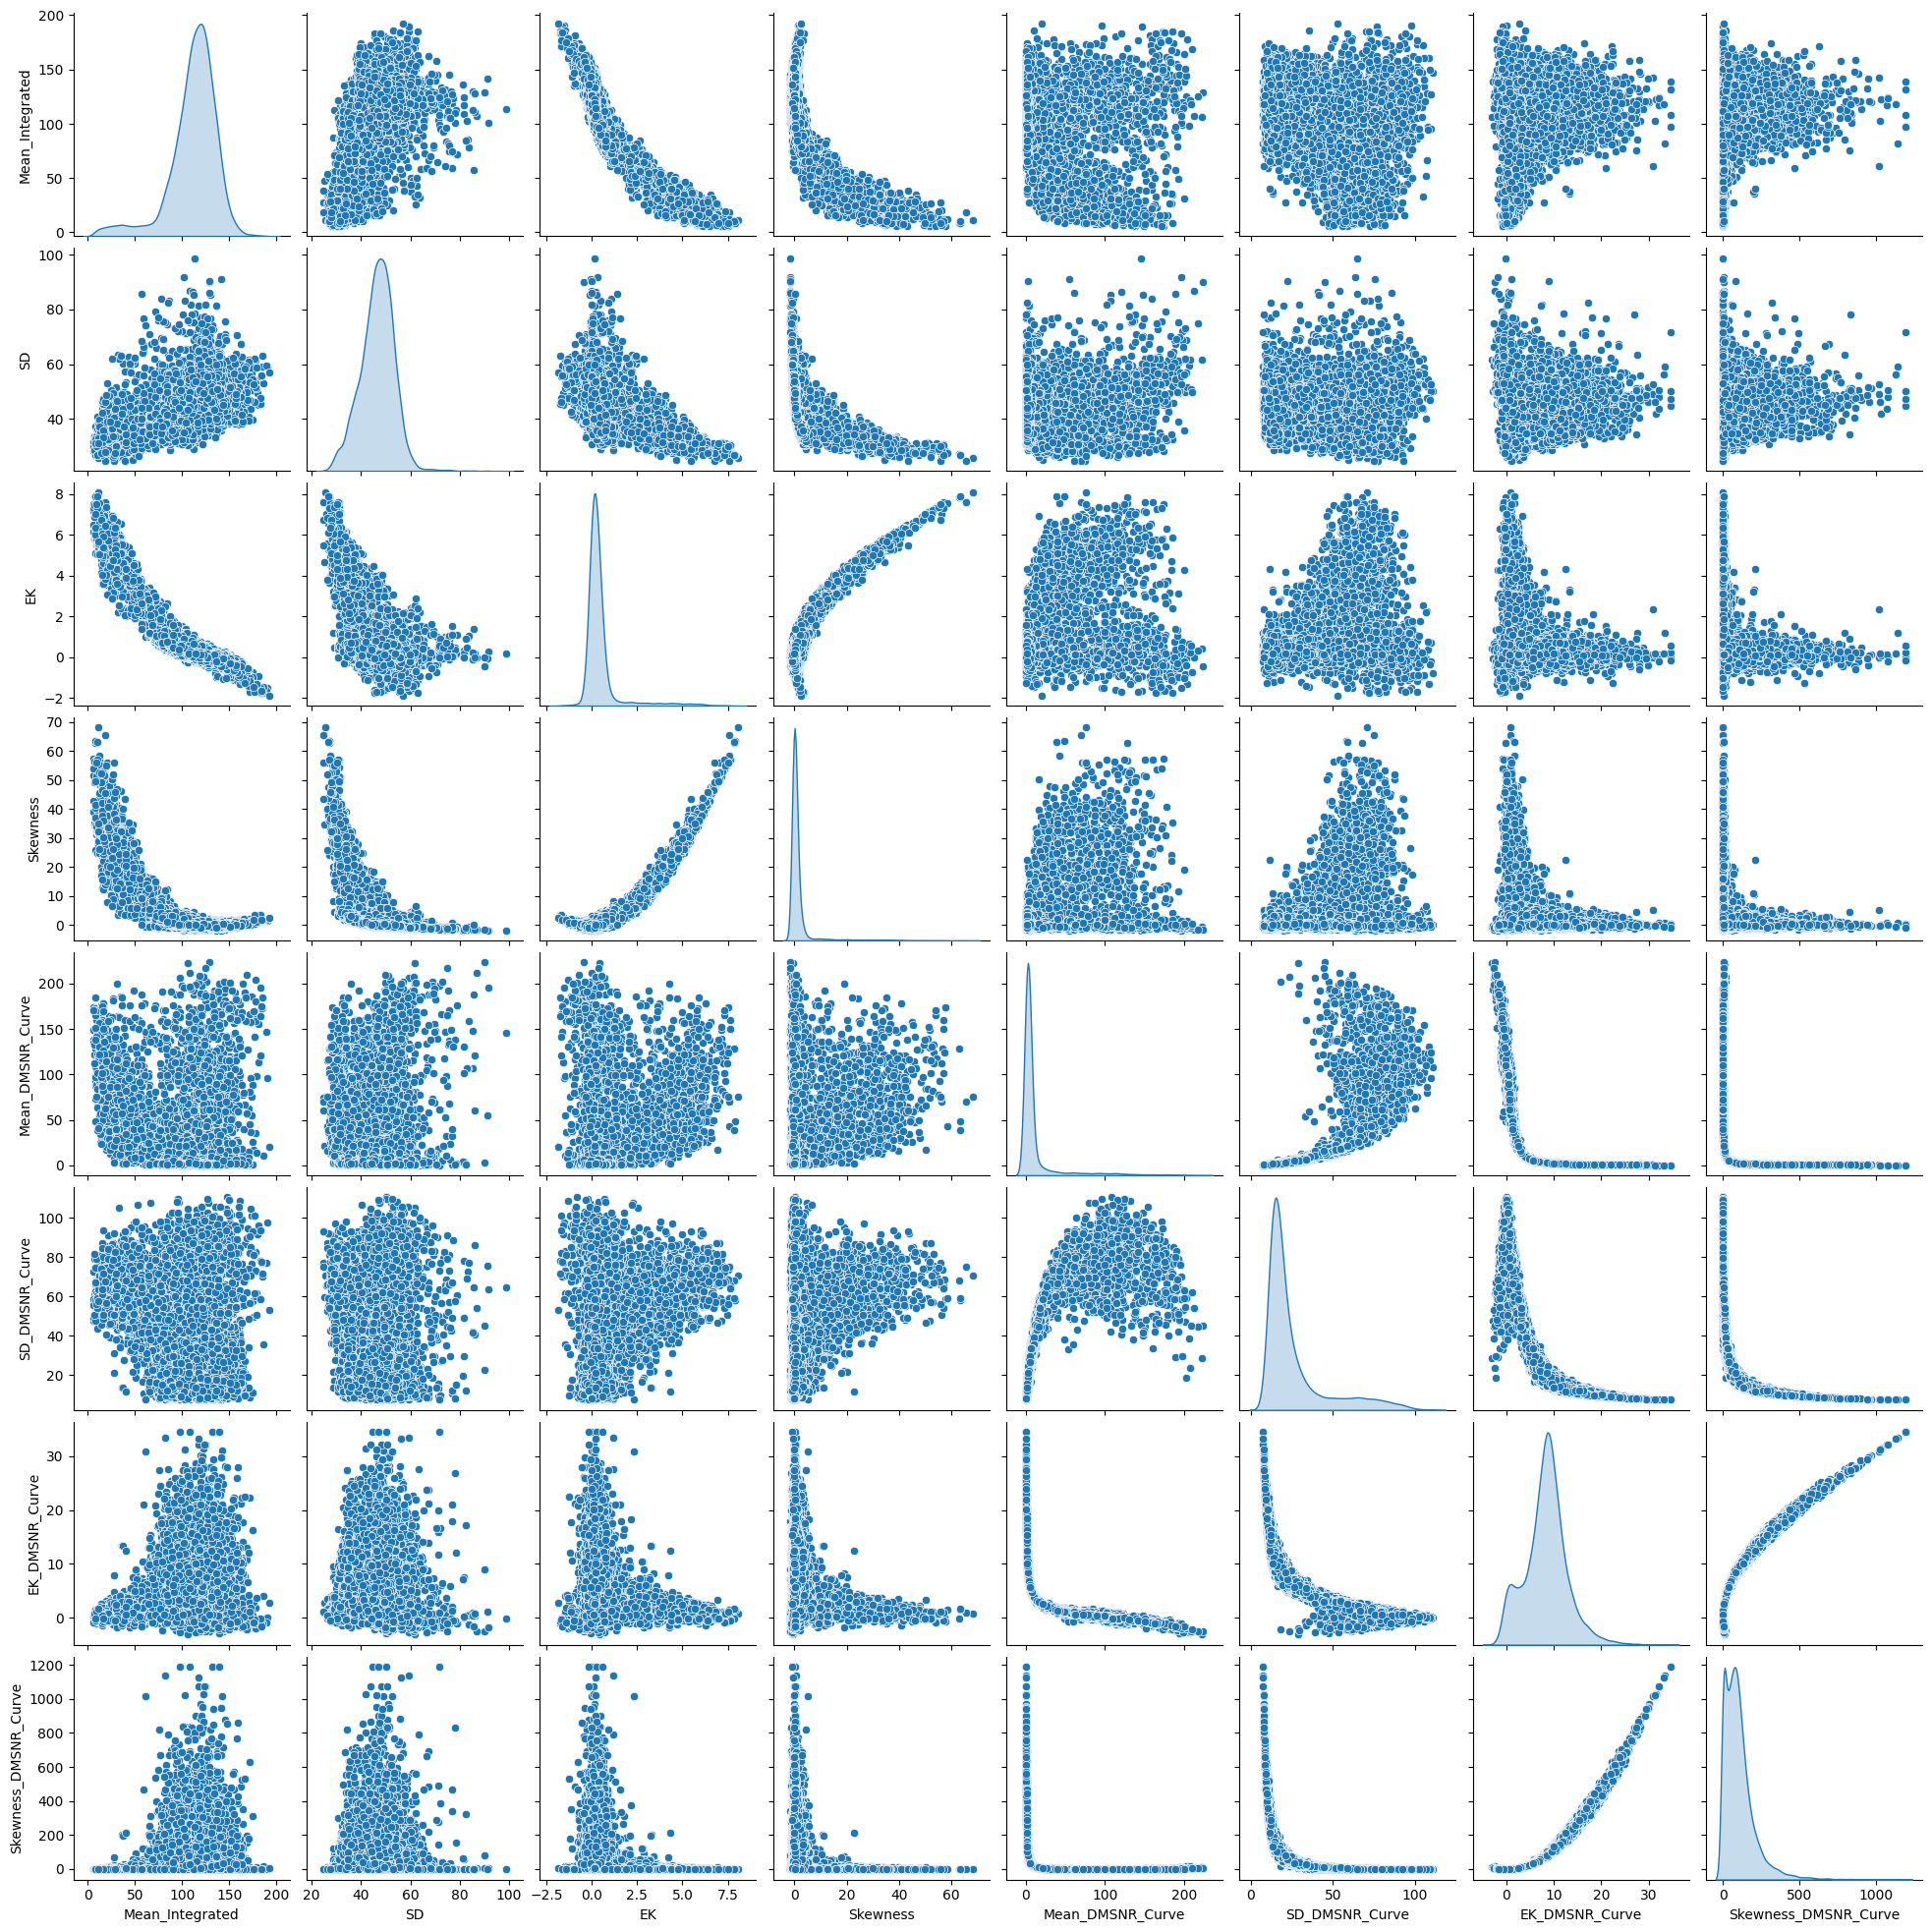

In [21]:
#Analizo visualmente las variables del dataset
sns.pairplot(Pulsar[['Mean_Integrated', 'SD', 'EK', 'Skewness','Mean_DMSNR_Curve','SD_DMSNR_Curve',
                     'EK_DMSNR_Curve','Skewness_DMSNR_Curve']],
                      diag_kind='kde')

**Conclusiones preliminares del análisis del dataset:**

1) El dataset no posee valores Nan, por lo que no se eliminan registros del mismo.

2) Al ser la media de la variable Class de 0.091 (9,1%), y con los queartiles 25%, 50% y 75% de 0.0, se ve que la base está desbalanceada porque la variable a predecir es menor al 10% del total de la muestra (1.639) de 17.898 registros.

3) Todas las variables son numéricas, ninguna categórica (texto), por lo que no se considera aplicar One Hot Encoding a alguna de ellas.

4) El dataset no tiene duplicados entre sus registros entre las 9 variables que contiene, incluída la variable a predecir "Class"


###**5) Se realiza la separación del dataset para entrenamiento, cross validation y test**

In [22]:
X = Pulsar.iloc[:,0:-1]
y = Pulsar['Class']

In [23]:
print(X.shape)
print(y.shape)

(17898, 8)
(17898,)


In [24]:
#Defino un a semilla para que no cambien los resultados de los split
np.random.seed(seed=2886)

In [25]:
#Divido el dataset en 3 utilizando Numpy (ya que train_test_split de scikit-learn no me lo permite):
X_train, X_test, X_val  = np.split(X, [int(.7*len(X)), int(.8*len(X))])
y_train, y_test, y_val  = np.split(y, [int(.7*len(y)), int(.8*len(y))])

In [26]:
print(X_train.shape) # 70% del dataset para entrenamiento del modelo
print(X_test.shape) # 10% del dataset para testeo del modelo
print(X_val.shape) # 20% del dataset para tuneo de hiperparámetros
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(12528, 8)
(1790, 8)
(3580, 8)
(12528,)
(1790,)
(3580,)


###**6) Entreno 1ero los hiperparámetros a aplicar utilizando el modelo "Hist Gradient Boosting Classifier"**

Fuente de consulta para evaluar el optimizador de hiperparámetros con cross validation: *Halving Random Search CV*

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html#sklearn.model_selection.HalvingRandomSearchCV

In [27]:
validation_hp = HistGradientBoostingClassifier()

param_dist =  {
              "max_depth": [10, 20, 50, 100, None], #profundidad máxima del árbol - default=None
              "max_iter": [100, 500, 1000], # El número máximo de árboles para la clasificación binaria - default=100
              "learning_rate": [0.01, 0.1, 1, 0.001] #learning rate - default=0.1
              }

rsh = HalvingRandomSearchCV(
    estimator=validation_hp, param_distributions=param_dist, factor=2, random_state = 2886,
    cv = 5 #"cv" determina los Kfolds o divisiones de la base para aplicar cross validation
)
rsh.fit(X_val, y_val)
rsh.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 60 is smaller than n_iter=179. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'max_iter': 500, 'max_depth': None, 'learning_rate': 0.001}

In [29]:
#Asigno los mejores hiperparámetros a variables para comenzar a entrenar el modelo:
lr = 0.001
max_depth = None
max_iter = 500
boost_1 = HistGradientBoostingClassifier().fit(X_train,y_train)

### **7) Entrenamiento del modelo y evaluación de resultados: hiperparámetros ajustados + todas las variables**

Antes de elegir las variables del modelo, evaluamos el mismo con la totalidad de las variables, para entender su performance previo a la selección de variables, y así tener una referencia

In [30]:
training_ds (boost_1,X_train,y_train,lr,max_depth,max_iter)


Elapsed training time: 2.35936 seconds


In [31]:
#Realizamos una predicción sobre las variables de entrenamiento (aún)
y_pred = boost_1.predict(X_train)
print(y_pred)

[0 0 0 ... 0 0 0]


In [32]:
#Evalúo el shape de la variable de entrenamiento y su predicción
print(y_train.shape)
print(y_pred.shape)

(12528,)
(12528,)


In [33]:
#Evalúo la performance del modelo en la base de entrenamiento
print(training_res(y_train,y_pred))

Se visualiza la matriz de confusión de los valores reales y su predicción:
[[10987    43]
 [  126  1372]]
-------------------------------------------
Acurracy / Exactitud del modelo:
0.9865
-------------------------------------------
Precisión del modelo:
0.9696
-------------------------------------------
Recall del modelo:
0.9159
None


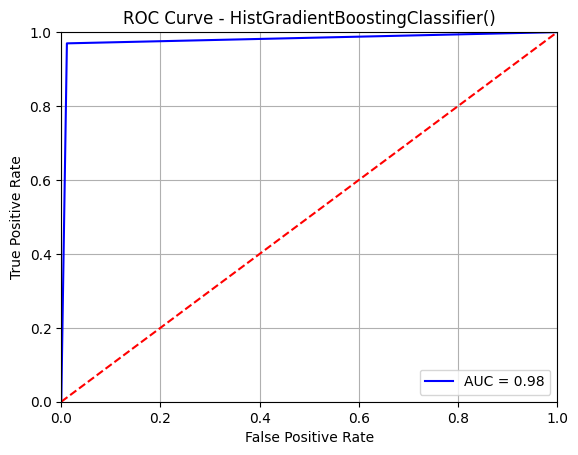

In [34]:
#Grafico la curva ROC y el área bajo la curva en Entrenamiento
grafico (boost_1,y_pred, y_train)

Si bien el modelo en training estima muy bien, hay que tener cuidado de que no sobreajuste.

### **8) Re-entreno varios modelos ajustando el Learning Rate a modo de prueba y se evalúan sus resultados**

In [35]:
#Defino nuevo valor para el learning Rate
lr2 = 0.1 #learning rate - default=0.1
boost_2 = HistGradientBoostingClassifier().fit(X_train,y_train)

lr3 = 0.01 #learning rate - default=0.1
boost_3 = HistGradientBoostingClassifier().fit(X_train,y_train)

lr4 = 1 #learning rate - default=0.1
boost_4 = HistGradientBoostingClassifier().fit(X_train,y_train)

In [36]:
#Re-entreno los respectivos modelos
print(training_ds (boost_2,X_train,y_train,lr2,max_depth,max_iter))
print('------------------------------')
print(training_ds (boost_3,X_train,y_train,lr3,max_depth,max_iter))
print('------------------------------')
print(training_ds (boost_4,X_train,y_train,lr4,max_depth,max_iter))


Elapsed training time: 0.31667 seconds
None
------------------------------

Elapsed training time: 1.86309 seconds
None
------------------------------

Elapsed training time: 0.06049 seconds
None


In [37]:
#Realizamos las predicciones sobre las variables de entrenamiento
y_pred_2 = boost_2.predict(X_train)
y_pred_3 = boost_3.predict(X_train)
y_pred_4 = boost_4.predict(X_train)

In [38]:
#Visualizamos los distintos resultados de los entrenamientos
print('Resultados entrenamiento boost_2')
print(training_res(y_train,y_pred_2))
print('-------------------------------------------')
print('\n')
print('Resultados entrenamiento boost_3')
print(training_res(y_train,y_pred_3))
print('-------------------------------------------')
print('\n')
print('Resultados entrenamiento boost_4')
print(training_res(y_train,y_pred_4))

Resultados entrenamiento boost_2
Se visualiza la matriz de confusión de los valores reales y su predicción:
[[11003    27]
 [   97  1401]]
-------------------------------------------
Acurracy / Exactitud del modelo:
0.9901
-------------------------------------------
Precisión del modelo:
0.9811
-------------------------------------------
Recall del modelo:
0.9352
None
-------------------------------------------


Resultados entrenamiento boost_3
Se visualiza la matriz de confusión de los valores reales y su predicción:
[[10994    36]
 [  113  1385]]
-------------------------------------------
Acurracy / Exactitud del modelo:
0.9881
-------------------------------------------
Precisión del modelo:
0.9747
-------------------------------------------
Recall del modelo:
0.9246
None
-------------------------------------------


Resultados entrenamiento boost_4
Se visualiza la matriz de confusión de los valores reales y su predicción:
[[10990    40]
 [  113  1385]]
---------------------------

Al ver los resultados, hay un claro ejemplo de que con los hiperparámetros preestablecidos, el mejor Learning Rate (lr) es el '0.01', tanto por su accuracy, precision y recall. Lo siguen el 0.1 y el 1, respectivamente.

### **9) Selecciono variables para el entrenamiento final del modelo, entreno y evalúo**

Se decide seleccionar 2 variables de las 8 del modelo. Para ello se agrupan las mismas según el tipo de medición que sean:


**SD, EK, Mean y Skewness**

In [39]:
#Creo nuevas variables X con 2 variables en lugar de 8
X1 = Pulsar.loc[:,['Mean_Integrated','Mean_DMSNR_Curve']]
X2 = Pulsar.loc[:,['SD','SD_DMSNR_Curve']]
X3 = Pulsar.loc[:,['EK','EK_DMSNR_Curve']]
X4 = Pulsar.loc[:,['Skewness','Skewness_DMSNR_Curve']]

In [40]:
#Por las dudas, re-defino la semilla
np.random.seed(seed=2886)

In [41]:
#Divido las nuevas variables X en train, validation y test
X_train1, X_test1, X_val1  = np.split(X1, [int(.7*len(X)), int(.8*len(X))])
X_train2, X_test2, X_val2  = np.split(X2, [int(.7*len(X)), int(.8*len(X))])
X_train3, X_test3, X_val3  = np.split(X3, [int(.7*len(X)), int(.8*len(X))])
X_train4, X_test4, X_val4  = np.split(X4, [int(.7*len(X)), int(.8*len(X))])

In [42]:
print(X_train1.shape)
print(X_test1.shape)
print(X_val1.shape)
print('------------------------')
print(X_train2.shape)
print(X_test2.shape)
print(X_val2.shape)
print('------------------------')
print(X_train3.shape)
print(X_test3.shape)
print(X_val3.shape)
print('------------------------')
print(X_train4.shape)
print(X_test4.shape)
print(X_val4.shape)

(12528, 2)
(1790, 2)
(3580, 2)
------------------------
(12528, 2)
(1790, 2)
(3580, 2)
------------------------
(12528, 2)
(1790, 2)
(3580, 2)
------------------------
(12528, 2)
(1790, 2)
(3580, 2)


No vuelvo a hacer el reentrenamiento de los parámetros ya que los resultados del modelo ya de por sí son bastante buenos. Utilizo los mismos resultantes para el dataset "Pulsar" completo, salvo por el LR que utilizo el lr3 (el de mejor resultado entre todos), de 0.01

In [43]:
lr3

0.01

In [44]:
#Defino los 4 modelos para cada par de variables, con hiperparámetros por default
boost_11 = HistGradientBoostingClassifier().fit(X_train1,y_train)
boost_12 = HistGradientBoostingClassifier().fit(X_train2,y_train)
boost_13 = HistGradientBoostingClassifier().fit(X_train3,y_train)
boost_14 = HistGradientBoostingClassifier().fit(X_train4,y_train)

In [45]:
#Entreno los 4 modelos con los hiperparámetros mencionados y con HistGradientBoostingClassifier
training_ds (boost_11,X_train1,y_train,lr3,max_depth,max_iter)
print('---------------------------------')
training_ds (boost_12,X_train2,y_train,lr3,max_depth,max_iter)
print('---------------------------------')
training_ds (boost_13,X_train3,y_train,lr3,max_depth,max_iter)
print('---------------------------------')
training_ds (boost_14,X_train4,y_train,lr3,max_depth,max_iter)


Elapsed training time: 1.96416 seconds
---------------------------------

Elapsed training time: 4.94485 seconds
---------------------------------

Elapsed training time: 1.43575 seconds
---------------------------------

Elapsed training time: 3.59846 seconds


In [46]:
#Realizamos las predicciones sobre las variables de entrenamiento
y_pred_11 = boost_11.predict(X_train1)
y_pred_12 = boost_12.predict(X_train2)
y_pred_13 = boost_13.predict(X_train3)
y_pred_14 = boost_14.predict(X_train4)

In [47]:
#Visualizamos los distintos resultados de los entrenamientos
print('Resultados entrenamiento boost_11') #Mean
print(training_res(y_train,y_pred_11))
print('-------------------------------------------')
print('\n')
print('Resultados entrenamiento boost_12') #SD
print(training_res(y_train,y_pred_12))
print('-------------------------------------------')
print('\n')
print('Resultados entrenamiento boost_13') #EK
print(training_res(y_train,y_pred_13))
print('-------------------------------------------')
print('\n')
print('Resultados entrenamiento boost_14') #Skewness
print(training_res(y_train,y_pred_14))

Resultados entrenamiento boost_11
Se visualiza la matriz de confusión de los valores reales y su predicción:
[[10946    84]
 [  279  1219]]
-------------------------------------------
Acurracy / Exactitud del modelo:
0.971
-------------------------------------------
Precisión del modelo:
0.9355
-------------------------------------------
Recall del modelo:
0.8138
None
-------------------------------------------


Resultados entrenamiento boost_12
Se visualiza la matriz de confusión de los valores reales y su predicción:
[[10909   121]
 [  528   970]]
-------------------------------------------
Acurracy / Exactitud del modelo:
0.9482
-------------------------------------------
Precisión del modelo:
0.8891
-------------------------------------------
Recall del modelo:
0.6475
None
-------------------------------------------


Resultados entrenamiento boost_13
Se visualiza la matriz de confusión de los valores reales y su predicción:
[[10961    69]
 [  204  1294]]
-------------------------

**Conclusión:** Si bien no llega al nivel de exactitud que cuando se utilizan las 8 variables, la variable que mejor predice el tipo de clase (Class) y que más se acerca al modelo general es el exceso de Kurtosis (EK), ya que tanto su accuracy, precisión como -principalmente- recall performan mejor que con el resto de las medidas.

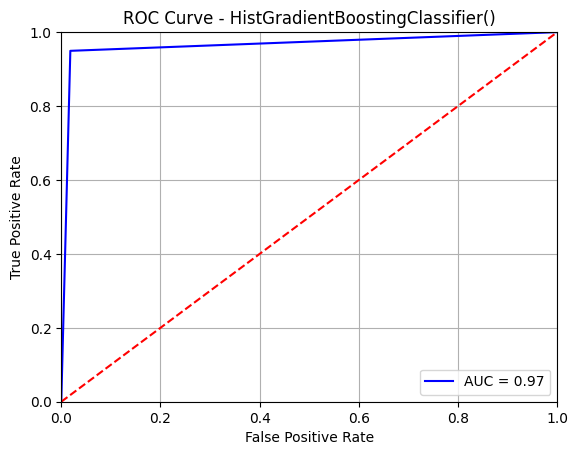

In [48]:
#Grafico la curva ROC y el área bajo la curva en Entrenamiento de EK (boost_13)
grafico (boost_13,y_pred_13, y_train)

### **10) Evalúo en testing el resultado final del entrenamiento**

In [49]:
#Realizo la predicción final utilizando los datos de testing
y_finalPred = boost_13.predict(X_test3)

In [50]:
#Visualizamos el resultado del modelo sobre la info de testeo
print('Resultado testeo')
print(training_res(y_test,y_finalPred))

Resultado testeo
Se visualiza la matriz de confusión de los valores reales y su predicción:
[[1674   28]
 [   9   79]]
-------------------------------------------
Acurracy / Exactitud del modelo:
0.9793
-------------------------------------------
Precisión del modelo:
0.7383
-------------------------------------------
Recall del modelo:
0.8977
None


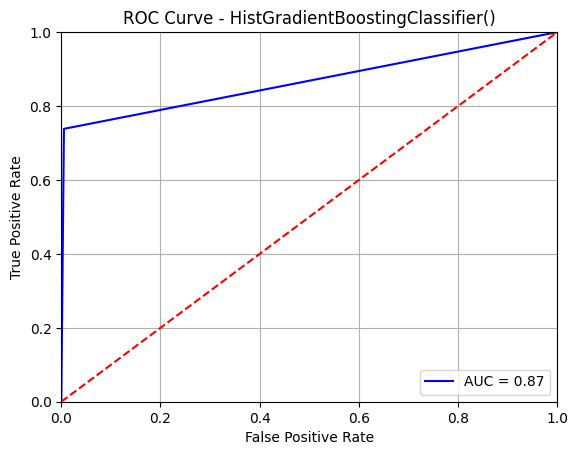

In [51]:
#Grafico la curva ROC y el área bajo la curva en testing
grafico (boost_13,y_finalPred, y_test)

**Conclusiones finales:** Es claro que hay un leve sobreajuste en entrenamiento, el cuál se puede seguir entrenando para mejores resultados, pero la performance en test sigue siguendo muy buena siendo que se utilizan únicamente 2 variables (EK) y que era evidente que en test los resultados iban a bajar un poco. Lo que deberá trabajarse principalmente es en aumentar la precisión y ver quizá de aplicar alguna técnica de aumentación de datos para los TRUE.

### **11) Realizo una predicción utilizando el modelo desarrollado**

In [83]:
new_value1 = [2.1,18.67]
new_values = pd.DataFrame([new_value1],columns=['EK','EK_DMSNR_Curve'])
print(new_values)

    EK  EK_DMSNR_Curve
0  2.1           18.67


In [86]:
prediction = pd.DataFrame(boost_13.predict(new_values),columns=['prediction'])

In [87]:
pd.concat([new_values,prediction],axis='columns')

,EK,EK_DMSNR_Curve,prediction
0,2.1,18.67,1


### **12) Importo el modelo en un PKL**

In [94]:
import pickle
# save the model to disk
filename = 'boost.pkl'
pickle.dump(boost_13, open(filename, 'wb'))